<a href="https://colab.research.google.com/github/youngseo21/esaa_22/blob/main/%EB%AF%B8%EB%8B%88_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83_%EC%98%81%ED%99%94%ED%9A%8C%EA%B7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [YB 미니 프로젝트3] 영화 관객수 예측

- 관련 사이트 : https://dacon.io/competitions/open/235536/codeshare
- 과제 : 미니 프로젝트(1)에 이어서, 한 학기동안 배운 회귀 모델들 중 하나 이상을 해당 데이터에 적합.
- 조건 : 하이퍼 파라미터 튜닝 포함

* 분석 파일을 1) 제출 후 리더보드에서 점수 확인 2) github에 업로드하여 점수와 깃허브 링크를 과제함에 댓글로 달아주시면 됩니다. 

* 제출기한 : 2022.12.30 (금) 23:59

* 평가 산식 : RMSE

In [1]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,617 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

# 출력 결과를 셀 아래 inline으로 표시
%matplotlib inline 

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## | 데이터 불러오기
---
+ title : 영화의 제목
+ distributor : 배급사
+ genre : 장르
+ release_time : 개봉일
+ time : 상영시간(분)
+ screening_rat : 상영등급
+ director : 감독이름
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스텝수
+ num_actor : 주연배우수
+ box_off_num : 관객수

In [44]:
train = pd.read_csv("/content/drive/MyDrive/esaa_data/movies/movies_train.csv")
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


- train data `dir_prev_bfnum` 결측치 330개 

In [8]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [45]:
test = pd.read_csv("/content/drive/MyDrive/esaa_data/movies/movies_test.csv")
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


- train data `dir_prev_bfnum` 결측치 136개

- `train`: 600개 데이터
- `test`: 243개 데이터

## | 결측치 확인 및 데이터 전처리
---
1. `title` drop
2. `distributor`, `genre`, `screening_rat`, `director` 범주형 변수 살펴보기 → 라벨 인코딩/원핫 인코딩 둘중 
  + `director`의 경우 범주가 너무 많아서 drop 고려
3. `release_time` datetime으로 바꾸고 날짜(365일)보다는 분기(계절), 휴일/평일이 관객 수와 더 연관있어 보임 → 계절, 휴일 여부에 관련한 새로운 칼럼 생성
4. train과 test 모두 `dir_prev_bfnum` 변수에 결측값 → 결측치 처리 방법 고민
5. `time`, `dir_prev_bfnum`,	`dir_prev_num`,	`num_staff`,	`num_actor`  숫자형 변수 → scaling


In [46]:
# train, test 데이터 합치기
train['from'] = 'train'
test['from'] = 'test'
total = train.append(test)
total.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train


### 1. `title` drop

In [32]:
#total.drop('title', axis=1, inplace=True)
#total.head(3)

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


### 2. `distributor`, `genre`, `screening_rat`, `director` 범주형 변수 살펴보기 → 라벨 인코딩/원핫 인코딩 둘중 
- `distributor`: 배급사

In [83]:
total['distributor'].value_counts().sort_values(ascending=False)[total['distributor'].value_counts().sort_values(ascending=False)>=10]

CJ            102
롯데             77
마운틴픽쳐스         49
NEW            48
쇼박스            42
인디스토리          37
골든타이드픽처스       27
시네마달           25
(주) 케이알씨지      19
KT             17
(주)키노아이        15
어뮤즈            13
영화사 진진         12
인디플러그          12
인벤트 디          12
리틀빅픽쳐스         12
(주) 영화사조제      12
시너지            11
(주)팝엔터테인먼트     10
Name: distributor, dtype: int64

In [56]:
total['distributor'].unique()

array(['롯데엔터테인먼트', '(주)쇼박스', '(주)NEW', '쇼박스(주)미디어플렉스', '백두대간',
       '유니버설픽쳐스인터내셔널코리아', '(주)두타연', '(주) 케이알씨지', '(주)콘텐츠 윙', '(주)키노아이',
       '(주)팝 파트너스', 'CJ E&M 영화부문', '(주) 영화제작전원사', 'CJ E&M Pictures',
       'CGV 무비꼴라쥬', '리틀빅픽처스', '스폰지', 'CJ 엔터테인먼트', 'CGV아트하우스', '조이앤시네마',
       '인디플러그', '콘텐츠판다', '인디스토리', '(주)팝엔터테인먼트', '시네마서비스', '웃기씨네',
       '영화사 진진', '(주)레인보우 팩토리', '김기덕 필름', 'NEW', 'CJ CGV',
       '동국대학교 충무로영상제작센터', 'BoXoo 엔터테인먼트', '(주)마운틴픽쳐스', 'CGV 아트하우스',
       '메가박스(주)플러스엠', '골든타이드픽처스', '파이오니아21', '디 씨드', '드림팩트 엔터테인먼트', '시너지',
       '디마엔터테인먼트', '판다미디어', '(주)스톰픽쳐스코리아', '(주)예지림 엔터테인먼트', '(주) 영화사조제',
       '보람엔터테인먼트', '(주)시네마달', '노바엔터테인먼트', '(주)패스파인더씨앤씨', '(주)대명문화공장',
       '(주)온비즈넷', 'KT&G 상상마당', '무비꼴라쥬', '인벤트 디', '씨네그루(주)키다리이엔티',
       '스튜디오후크', '시네마 달', '나이너스엔터테인먼트(주)', 'THE 픽쳐스', '영구아트무비', '리틀빅픽쳐스',
       '어뮤즈', '이모션 픽처스', '(주)이스트스카이필름', '필라멘트 픽쳐스', '조이앤컨텐츠그룹', '타임스토리그룹',
       '마운틴 픽처스', '(주)휘엔터테인먼트', '이십세기폭스코리아(주)', '(주)피터팬픽쳐스', '에스와이코마드',
       '(주)더픽쳐스', '오퍼스픽쳐스'

- 똑같은 배급사가 다르게 표기된 경우가 있음 ex. '(주)' 앞/뒤 혹은 없음 중복, 띄어쓰기 등
- 겹치는 배급사가 많은 것 위주로 찾아보자
  - 'CJ 엔터테인먼트' 'CJ E&M Pictures' 'CJ E&M 영화부문' 'CJ CGV' 'CGV 아트하우스' 'CGV아트하우스' 'CGV 무비꼴라쥬' → `'CJ'`
  - '마운틴 픽처스' '더픽쳐스/(주)마운틴픽쳐스' '(주)마운틴픽쳐스' '마운틴픽쳐스' '(주)씨타마운틴픽쳐스' → `'마운틴픽쳐스'`
  - '(주)쇼박스' '쇼박스(주)미디어플렉스' → `'쇼박스'`
  - '(주)NEW' 'NEW' → `'NEW'`
  - 'KT&G 상상마당' 'KT' → `'KT'`
  - '롯데엔터테인먼트' '롯데쇼핑(주)롯데엔터테인먼트' → `'롯데'`
  - '싸이더스FNH' '싸이더스' '싸이더스 FNH' → `'싸이더스'`
  - '(주)리틀빅픽처스' '리틀빅픽처스' '리틀빅픽쳐스' → `'리틀빅픽처스'`
  - '(주)마인스엔터테인먼트' '(주)마인스 엔터테인먼트' → `'마인스엔터테인먼트'`
  - 'SK플래닛' 'SK텔레콤(주)' → `'SK'`
  - '(주)시네마달' '시네마 달' '시네마달' → `시네마달'`
  - 'THE 픽쳐스' '(주)더픽쳐스' → `'더픽쳐스'`
  - '메가박스중앙(주)플러스엠' '메가박스(주)플러스엠' → `'메가박스'`
  - '(주)디씨드' '디씨드' '디 씨드' → `'디씨드'`

In [72]:
total['distributor'] = total['distributor'].replace(['CJ 엔터테인먼트', 'CJ E&M Pictures', 'CJ E&M 영화부문', 'CJ CGV', 'CGV 아트하우스', 'CGV아트하우스', 'CGV 무비꼴라쥬'], ['CJ']*7)
total['distributor'] = total['distributor'].replace(['마운틴 픽처스', '더픽쳐스/(주)마운틴픽쳐스', '(주)마운틴픽쳐스', '마운틴픽쳐스', '(주)씨타마운틴픽쳐스'], ['마운틴픽쳐스']*5)
total['distributor'] = total['distributor'].replace(['(주)쇼박스', '쇼박스(주)미디어플렉스' ], ['쇼박스']*2)
total['distributor'] = total['distributor'].replace(['(주)NEW', 'NEW' ], ['NEW']*2)
total['distributor'] = total['distributor'].replace(['KT&G 상상마당', 'KT' ], ['KT']*2)
total['distributor'] = total['distributor'].replace(['롯데엔터테인먼트', '롯데쇼핑(주)롯데엔터테인먼트' ], ['롯데']*2)
total['distributor'] = total['distributor'].replace(['싸이더스FNH', '싸이더스', '싸이더스 FNH'], ['싸이더스']*3)
total['distributor'] = total['distributor'].replace(['(주)리틀빅픽처스', '리틀빅픽처스', '리틀빅픽쳐스' ], ['리틀빅픽쳐스']*3)
total['distributor'] = total['distributor'].replace(['(주)마인스엔터테인먼트', '(주)마인스 엔터테인먼트' ], ['마인스엔터테인먼트']*2)
total['distributor'] = total['distributor'].replace(['SK플래닛', 'SK텔레콤(주)' ], ['SK']*2)
total['distributor'] = total['distributor'].replace(['(주)시네마달', '시네마 달', '시네마달' ], ['시네마달']*3)
total['distributor'] = total['distributor'].replace(['THE 픽쳐스', '(주)더픽쳐스' ], ['더픽쳐스']*2)
total['distributor'] = total['distributor'].replace(['메가박스중앙(주)플러스엠', '메가박스(주)플러스엠' ], ['메가박스']*2)
total['distributor'] = total['distributor'].replace(['(주)디씨드', '디씨드', '디 씨드' ], ['디씨드']*3)

In [84]:
# 1개 이상 영화 배급사
total['distributor'].value_counts().sort_values(ascending=False)[total['distributor'].value_counts().sort_values()>1]

CJ            102
롯데             77
마운틴픽쳐스         49
NEW            48
쇼박스            42
             ... 
서울독립영화제         2
(주)프레인글로벌       2
SK              2
씨네굿필름           2
에이원 엔터테인먼트      2
Name: distributor, Length: 71, dtype: int64

- `genre`: 장르 → 전처리 할거 없음, 굳이 한다면 서스펜스랑 미스터리 합치는거? 

In [85]:
total['genre'].value_counts().sort_values(ascending=False)

드라마       299
다큐멘터리     126
멜로/로맨스    117
코미디        76
공포         61
액션         49
느와르        39
애니메이션      29
미스터리       24
SF         14
뮤지컬         6
서스펜스        3
Name: genre, dtype: int64

In [92]:
total[total['genre']=='서스펜스']

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from
13,짓,(주)팝 파트너스,서스펜스,2013-09-25,107,청소년 관람불가,한종훈,534232.5,2,15,4,23052.0,train
269,가시,인벤트 디,서스펜스,2014-04-10,117,청소년 관람불가,김태균,NaN,0,207,2,142170.0,train
52,링크,(주)키노아이,서스펜스,2011-07-28,105,청소년 관람불가,우디 한,NaN,0,96,5,NaN,test


- `screening_rat`: 상영등급 → 전처리 할거 없음

In [93]:
total['screening_rat'].value_counts().sort_values(ascending=False)

청소년 관람불가    297
15세 관람가     275
12세 관람가     142
전체 관람가      129
Name: screening_rat, dtype: int64

- `director`: 감독이름 → 범주가 너무 많아 drop 고려
  - 총 843개 데이터 중 458개는 감독 unique
  - 한 감독 당 3개 이상 영화는 총 169개 데이터

In [97]:
total['director'].value_counts().sort_values(ascending=False)[total['director'].value_counts().sort_values()==1]

배광수    1
임상윤    1
박진표    1
권혁만    1
심형래    1
      ..
조용선    1
양지은    1
김지곤    1
이제락    1
송동윤    1
Name: director, Length: 458, dtype: int64

In [101]:
total['director'].value_counts().sort_values(ascending=False)[total['director'].value_counts().sort_values()>2].sum()

169

In [104]:
total['director'].value_counts().sort_values(ascending=False)[total['director'].value_counts().sort_values()>3]

홍상수    8
전규환    6
조성규    6
우민호    4
오멸     4
민규동    4
장진     4
윤여창    4
이준익    4
노진수    4
곽경택    4
신연식    4
이상우    4
장률     4
김성훈    4
신재호    4
김봉은    4
Name: director, dtype: int64

### 3. `release_time`: 개봉날짜
datetime형으로 바꾸고 날짜(365일)보다는 분기(계절), 휴일/평일이 관객 수와 더 연관있어 보임 → 계절, 휴일 여부에 관련한 새로운 칼럼 생성
- datetime에서 month 추출
- 한국 기준 공휴일, 주말/평일 추출


In [106]:
# datetime형으로 바꾸기
from datetime import datetime

total['release_time'] = pd.to_datetime(total['release_time']) 
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 0 to 242
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           843 non-null    object        
 1   distributor     843 non-null    object        
 2   genre           843 non-null    object        
 3   release_time    843 non-null    datetime64[ns]
 4   time            843 non-null    int64         
 5   screening_rat   843 non-null    object        
 6   director        843 non-null    object        
 7   dir_prev_bfnum  377 non-null    float64       
 8   dir_prev_num    843 non-null    int64         
 9   num_staff       843 non-null    int64         
 10  num_actor       843 non-null    int64         
 11  box_off_num     600 non-null    float64       
 12  from            843 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 124.5+ KB


In [107]:
total.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from
0,개들의 전쟁,롯데,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train
3,나는 공무원이다,NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866.0,train
4,불량남녀,쇼박스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387.0,train


In [108]:
# year, month 추출해서 새로운 컬럼으로 
total["year"] = total["release_time"].dt.year
total["month"] = total["release_time"].dt.month
total.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month
0,개들의 전쟁,롯데,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train,2012,11
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train,2015,11
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train,2013,6
3,나는 공무원이다,NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866.0,train,2012,7
4,불량남녀,쇼박스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387.0,train,2010,11


In [110]:
total['year'].unique()

array([2012, 2015, 2013, 2010, 2014, 2011])

- 해당 데이터는 2010년부터 2015년까지있음

In [133]:
# 주말/평일 구분 --> x 
from datetime import datetime, date

#def is_weekend(date):
#    return date.weekday() > 4
#
#weekend = []
#for i in total['release_time']:
#  a = is_weekend(i)
#  weekend.append(a)
#
#total['weekend'] = weekend
#total['weekend'].value_counts()

total['release_time'].dt.weekday.value_counts() # 0이 월요일, 6이 일요일
# 주말이 2개 뿐...

3    675
2    156
0      4
1      4
4      2
5      1
6      1
Name: release_time, dtype: int64

In [5]:
! pip install pytimekr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytimekr: filename=pytimekr-0.1.0-py3-none-any.whl size=7941 sha256=7f851771498959f18cc8a3e5af2ce70ea320b1a9a3f3c7bb630b508eb721a13b
  Stored in directory: /root/.cache/pip/wheels/f4/b3/6a/4a916f486c95f31b533d394ea247a35dd3496a75cc74a562d9
Successfully built pytimekr


In [6]:
from pytimekr import pytimekr
# 한국 공유일: 추석, 설날, 한글날, 어린이날, 광복절, 현충일, 석가탄신일, 삼일절, 제헌절 
# 추석, 설날, 어린이날 관객수 높은 상관관계 예상

# 연도별 공유일 날짜 구하기
holiday = []
for i in range(2010, 2015):
    new = pytimekr.lunar_newyear(i) # 설날
    holiday.append(new)
    chi = pytimekr.children(i) # 어린이날
    holiday.append(chi)
    han = pytimekr.hangul(i) # 한글날
    holiday.append(han)
    ind = pytimekr.independence(i) # 광복절
    holiday.append(ind)
    chu = pytimekr.chuseok(i) # 추석
    holiday.append(chu)
    mem = pytimekr.memorial(i) # 헌충일
    holiday.append(mem)
    bud = pytimekr.buddha(i) # 석가탄신일
    holiday.append(bud)
    sam = pytimekr.samiljeol(i) # 삼일절
    holiday.append(sam)
    con = pytimekr.constitution(i) # 제헌절
    holiday.append(con)

def is_holiday(date):
  if date in holiday:
    return 1 # 공휴일이면 1
  else:
    return 0 # 아니면 0

holidays = []
for i in total['release_time']:
  a = is_holiday(i)
  holidays.append(a)

total['holiday'] = holidays
total['holiday'].value_counts() # 15개 데이터가 공휴일에 개봉

0    828
1     15
Name: holiday, dtype: int64

In [151]:
# release_time 컬럼 drop
total.drop(columns="release_time", axis=1, inplace=True)
total.head()

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month,holiday
0,롯데,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train,2012,11,0
1,쇼박스,느와르,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train,2015,11,0
2,쇼박스,액션,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train,2013,6,0
3,NEW,코미디,101,전체 관람가,구자홍,23894.00,2,20,6,217866.0,train,2012,7,0
4,쇼박스,코미디,108,15세 관람가,신근호,1.00,1,251,2,483387.0,train,2010,11,0


### 4. train과 test 모두 `dir_prev_bfnum` 변수에 결측값 → 결측치 처리 방법 고민
`dir_prev_bfnum`: 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)

`dir_prev_num` : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- 466 개 너무 많음
- drop 고민..
- 감독이 겹치는 결측치 고려
- 안겹치면 → `0`


In [9]:
total[total.dir_prev_bfnum.isna()]

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month,holiday
0,개들의 전쟁,롯데,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train,2012,11,False
6,길위에서,백두대간,다큐멘터리,104,전체 관람가,이창재,NaN,0,32,5,53526.0,train,2013,5,False
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,129,전체 관람가,정성복,NaN,0,3,5,4778.0,train,2014,9,False
9,청춘그루브,(주)두타연,드라마,94,15세 관람가,변성현,NaN,0,138,3,868.0,train,2012,3,False
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745.0,train,2015,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,타이밍,(주)스톰픽쳐스코리아,애니메이션,100,15세 관람가,민경조,NaN,0,56,1,NaN,test,2015,12,False
237,어떤이의 꿈,하준사,드라마,72,12세 관람가,조성규,NaN,0,29,3,NaN,test,2015,11,False
239,울보 권투부,인디스토리,다큐멘터리,86,12세 관람가,이일하,NaN,0,18,2,NaN,test,2015,10,False
240,어떤살인,(주)컨텐츠온미디어,느와르,107,청소년 관람불가,안용훈,NaN,0,224,4,NaN,test,2015,10,False


In [14]:
total[total.dir_prev_bfnum.isna()]['director'].value_counts().sort_values(ascending=False)[total[total.dir_prev_bfnum.isna()]['director'].value_counts()>1]

홍상수    7
조성규    6
전규환    6
장률     4
노진수    4
      ..
박정범    2
방현준    2
백승화    2
민용근    2
이병헌    2
Name: director, Length: 70, dtype: int64

In [15]:
# 홍상수 8개 영화 데이터 중 7개만 null 값
total[total['director']=='홍상수']

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month,holiday
15,자유의 언덕,(주) 영화제작전원사,드라마,67,청소년 관람불가,홍상수,NaN,0,52,3,39317.0,train,2014,9,False
19,하하하,스폰지,드라마,115,청소년 관람불가,홍상수,NaN,0,74,9,57029.0,train,2010,5,True
115,북촌방향,(주) 영화사조제,드라마,79,청소년 관람불가,홍상수,NaN,0,55,5,46212.0,train,2011,9,False
164,지금은맞고그때는틀리다,NEW,드라마,121,청소년 관람불가,홍상수,39317.0,1,16,2,80734.0,train,2015,9,False
331,다른나라에서,(주) 영화제작전원사,드라마,89,청소년 관람불가,홍상수,NaN,0,70,2,31101.0,train,2012,5,False
506,우리 선희,(주) 영화제작전원사,드라마,89,청소년 관람불가,홍상수,NaN,0,8,6,69122.0,train,2013,9,False
523,옥희의 영화,스폰지,드라마,80,청소년 관람불가,홍상수,NaN,0,57,3,37122.0,train,2010,9,False
107,누구의 딸도 아닌 해원,(주) 영화제작전원사,드라마,90,청소년 관람불가,홍상수,NaN,0,56,3,NaN,test,2013,2,False


- 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수 (알려지지 않은 경우 포함) = 0  →  `dir_prev_bfnum` null 값? 전부.. 0으로 채워도 될 듯

In [16]:
total[total.dir_prev_bfnum.isna()][total[total.dir_prev_bfnum.isna()]['dir_prev_num']==0]

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month,holiday
0,개들의 전쟁,롯데,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train,2012,11,False
6,길위에서,백두대간,다큐멘터리,104,전체 관람가,이창재,NaN,0,32,5,53526.0,train,2013,5,False
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,129,전체 관람가,정성복,NaN,0,3,5,4778.0,train,2014,9,False
9,청춘그루브,(주)두타연,드라마,94,15세 관람가,변성현,NaN,0,138,3,868.0,train,2012,3,False
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745.0,train,2015,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,타이밍,(주)스톰픽쳐스코리아,애니메이션,100,15세 관람가,민경조,NaN,0,56,1,NaN,test,2015,12,False
237,어떤이의 꿈,하준사,드라마,72,12세 관람가,조성규,NaN,0,29,3,NaN,test,2015,11,False
239,울보 권투부,인디스토리,다큐멘터리,86,12세 관람가,이일하,NaN,0,18,2,NaN,test,2015,10,False
240,어떤살인,(주)컨텐츠온미디어,느와르,107,청소년 관람불가,안용훈,NaN,0,224,4,NaN,test,2015,10,False


In [17]:
total['dir_prev_bfnum']=total['dir_prev_bfnum'].fillna(0)

In [18]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 0 to 242
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           843 non-null    object 
 1   distributor     843 non-null    object 
 2   genre           843 non-null    object 
 3   time            843 non-null    int64  
 4   screening_rat   843 non-null    object 
 5   director        843 non-null    object 
 6   dir_prev_bfnum  843 non-null    float64
 7   dir_prev_num    843 non-null    int64  
 8   num_staff       843 non-null    int64  
 9   num_actor       843 non-null    int64  
 10  box_off_num     600 non-null    float64
 11  from            843 non-null    object 
 12  year            843 non-null    int64  
 13  month           843 non-null    int64  
 14  holiday         843 non-null    bool   
dtypes: bool(1), float64(2), int64(6), object(6)
memory usage: 99.6+ KB


## | EDA
---
+ title : 영화의 제목
+ distributor : 배급사
+ genre : 장르
+ time : 상영시간(분)
+ screening_rat : 상영등급
+ director : 감독이름
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스텝수
+ num_actor : 주연배우수
+ box_off_num : 관객수 (target)
+ from : train, test 구분
+ year : 개봉 년도
+ month : 개봉 월
+ holiday : 개봉일이 공휴일이였는지 여부 (1: yes, 0: no)

1. `dir_prev_bfnum`와 `dir_prev_num` 간 상관관계
2. `release_time` 관련해서 새로 만든 변수 `box_off_num` 상관 있는지


In [19]:
total.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month,holiday
0,개들의 전쟁,롯데,액션,96,청소년 관람불가,조병옥,0.00,0,91,2,23398.0,train,2012,11,False
1,내부자들,쇼박스,느와르,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train,2015,11,False
2,은밀하게 위대하게,쇼박스,액션,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train,2013,6,False
3,나는 공무원이다,NEW,코미디,101,전체 관람가,구자홍,23894.00,2,20,6,217866.0,train,2012,7,False
4,불량남녀,쇼박스,코미디,108,15세 관람가,신근호,1.00,1,251,2,483387.0,train,2010,11,False


## 1. 숫자형 변수
+ time : 상영시간(분)
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스텝수
+ num_actor : 주연배우수

+ box_off_num : 관객수 (target)


#### 1) time

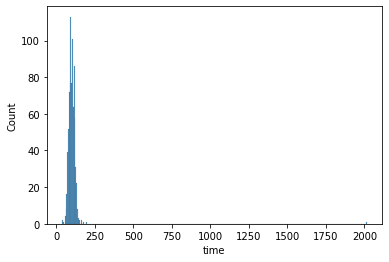

In [30]:
sns.histplot(total['time'])

+ 이상치 있음
+ time변수 skewed 

In [33]:
total['time'].sort_values(ascending=False)

224    2015
33      198
377     180
438     166
209     163
       ... 
319      60
201      60
130      50
545      45
140      40
Name: time, Length: 843, dtype: int64

In [34]:
# 데이터 한 값이 너무 큼
total[total['time']==2015]

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month,holiday
224,슈퍼레이서 엔지,(주)에이원 엔터테인먼트,애니메이션,2015,전체 관람가,허선,0.0,0,4,5,NaN,test,2015,9,False


+ 영화 '슈퍼레이서 엔지'의 경우 2015년 개봉, 1시간 3분 런닝 타임으로 데이터 잘못 입력됨을 확인 -> `time = 63`으로 고쳐

In [39]:
# 이상치 셀 값 바꾸기
total.loc[total['time']==2015, 'time'] = 63

In [40]:
total[total['title']=='슈퍼레이서 엔지']

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month,holiday
224,슈퍼레이서 엔지,(주)에이원 엔터테인먼트,애니메이션,63,전체 관람가,허선,0.0,0,4,5,NaN,test,2015,9,False


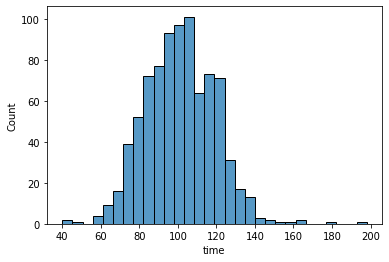

In [41]:
sns.histplot(total['time'])

+ time --> 정규화

#### 2) dir_prev_bfnum

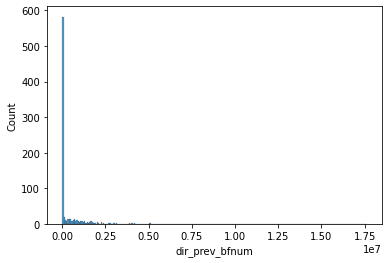

In [29]:
sns.histplot(total['dir_prev_bfnum'])

In [42]:
total['dir_prev_bfnum'].sort_values(ascending=False)

338    17615314.0
214     8801639.0
16      8223342.0
118     7855474.0
409     7838528.5
          ...    
364           0.0
365           0.0
366           0.0
368           0.0
242           0.0
Name: dir_prev_bfnum, Length: 843, dtype: float64

+ dir_prev_bfnum 변수 skewed -> log 변환

#### 3) dir_prev_num 

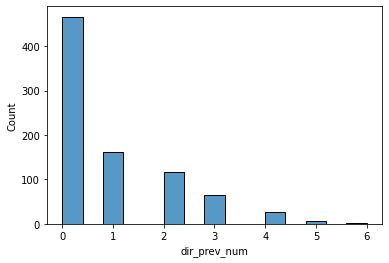

In [28]:
sns.histplot(total['dir_prev_num'])

+ equal constant length 1
+ scaling 고민... -> Min-Max scaler

#### 4) num_staff

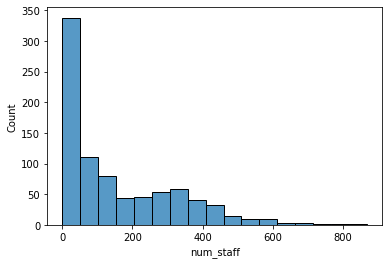

In [27]:
sns.histplot(total['num_staff'])

+ num_staff 변수 skewed -> log 변환

#### 5) num_actor

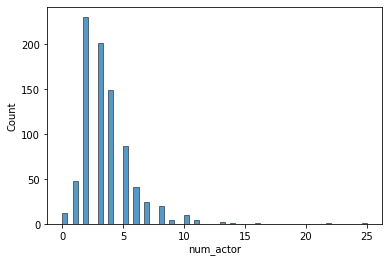

In [26]:
sns.histplot(total['num_actor'])

+ num_actor skewed 정도가 심하지 않으나 정규화 -> standard scaler

6) box_off_num (target)

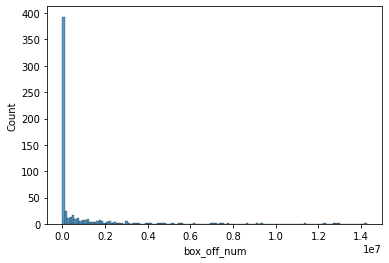

In [31]:
sns.histplot(total['box_off_num'])

+ box_off_num 변수 skewed -> log 변환

In [24]:
# numerical 변수 scaling
log_col = ['box_off_num', 'num_staff', 'dir_prev_num', 'dir_prev_bfnum']
standard_col = ['num_actor', 'time']
minmax_col = 'dir_prev_num'

# 로그 변환
total[log_col] = np.log1p(total[log_col])
# standardization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()
standard_scaler.fit(total[standard_col])
total[standard_col] = standard_scaler.transform(total[standard_col])
# min max scaling
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(total[[minmax_col]]) # caution: single col은 series말고 dataframe으로 
total[[minmax_col]] = minmax_scaler.transform(total[[minmax_col]])

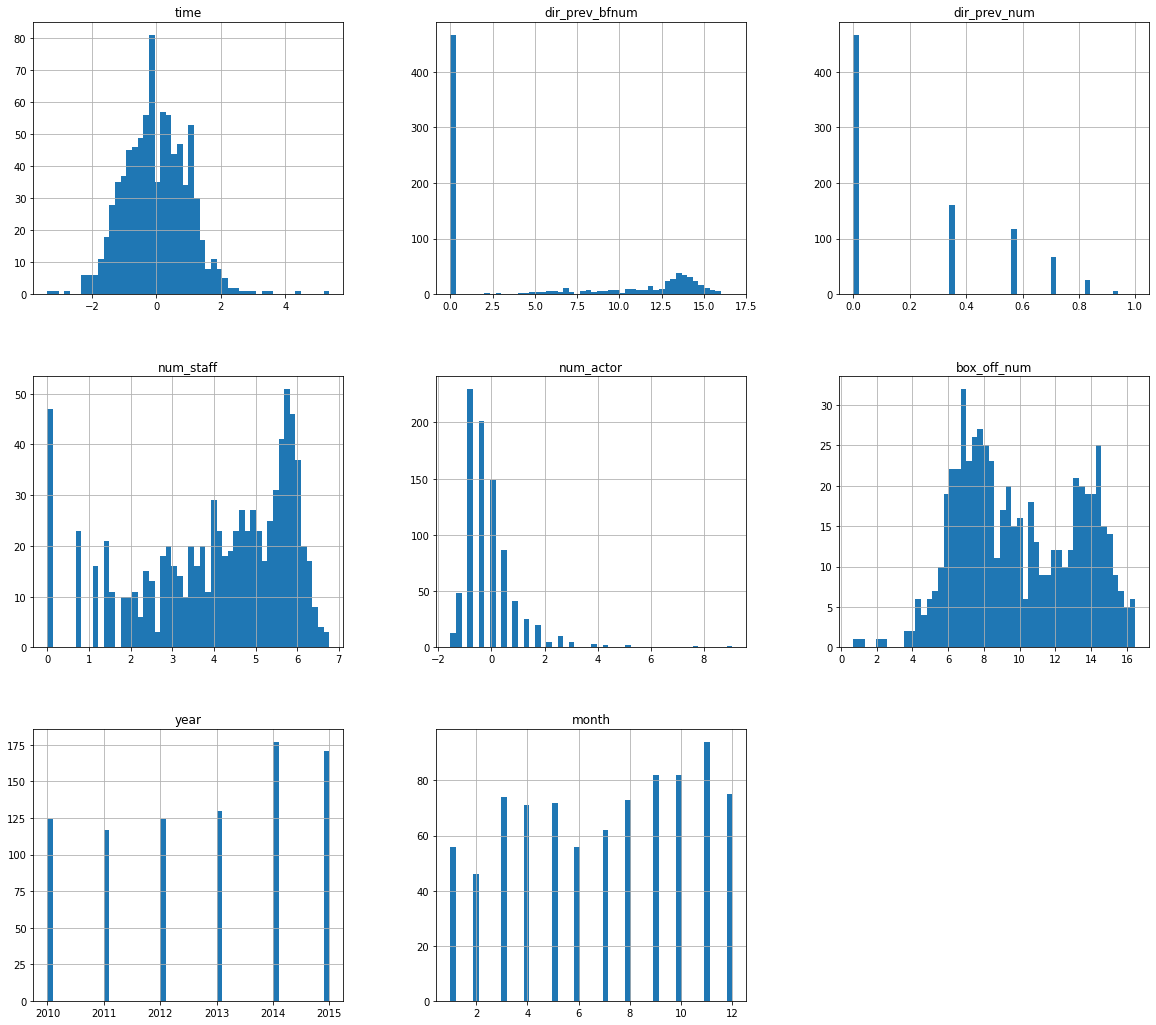

In [26]:
numerical = log_col + standard_col + [minmax_col]
_ = total.hist(bins=50, figsize=(20, 18))

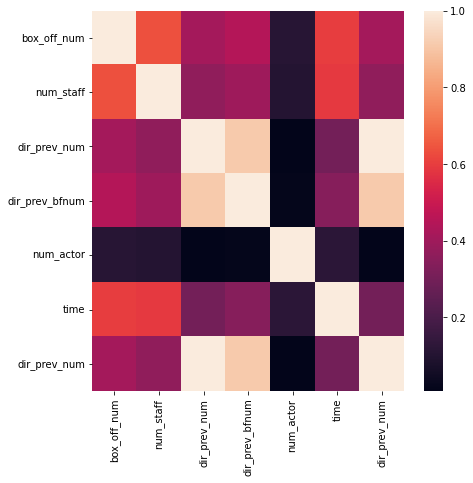

In [31]:
corr = total[numerical].corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, fmt = '.lg')

+ dir_prev_num & dir_prev_bfnum 높은 상관관계
+ box_off_num의 경우 num_staff와 time이 높은 상관관계를 가지며 num_actor과는 낮은 상관관계를 가짐


### 2. 범주형 변수
label_encoding 혹은 one_hot_encoding?
+ distributor : 배급사
+ genre : 장르
+ screening_rat : 상영등급
+ director : 감독이름
+ year : 개봉 년도
+ month : 개봉 월
+ holiday : 개봉일이 공휴일이였는지 여부 (1: yes, 0: no)


#### 1) distributor

In [33]:
total.distributor.unique()

array(['롯데', '쇼박스', 'NEW', '백두대간', '유니버설픽쳐스인터내셔널코리아', '(주)두타연',
       '(주) 케이알씨지', '(주)콘텐츠 윙', '(주)키노아이', '(주)팝 파트너스', 'CJ',
       '(주) 영화제작전원사', '리틀빅픽쳐스', '스폰지', '조이앤시네마', '인디플러그', '콘텐츠판다',
       '인디스토리', '(주)팝엔터테인먼트', '시네마서비스', '웃기씨네', '영화사 진진', '(주)레인보우 팩토리',
       '김기덕 필름', '동국대학교 충무로영상제작센터', 'BoXoo 엔터테인먼트', '마운틴픽쳐스', '메가박스',
       '골든타이드픽처스', '파이오니아21', '디씨드', '드림팩트 엔터테인먼트', '시너지', '디마엔터테인먼트',
       '판다미디어', '(주)스톰픽쳐스코리아', '(주)예지림 엔터테인먼트', '(주) 영화사조제', '보람엔터테인먼트',
       '시네마달', '노바엔터테인먼트', '(주)패스파인더씨앤씨', '(주)대명문화공장', '(주)온비즈넷', 'KT',
       '무비꼴라쥬', '인벤트 디', '씨네그루(주)키다리이엔티', '스튜디오후크', '나이너스엔터테인먼트(주)',
       '더픽쳐스', '영구아트무비', '어뮤즈', '이모션 픽처스', '(주)이스트스카이필름', '필라멘트 픽쳐스',
       '조이앤컨텐츠그룹', '타임스토리그룹', '(주)휘엔터테인먼트', '이십세기폭스코리아(주)', '(주)피터팬픽쳐스',
       '에스와이코마드', '오퍼스픽쳐스', '(주)고앤고 필름', '사람과 사람들', '(주)JK필름',
       '씨너스엔터테인먼트(주)', '싸이더스', '(주)프레인글로벌', '나우콘텐츠', '홀리가든', '(주) 브릿지웍스',
       '(주)엣나인필름', '위더스필름', '(주)에이원 엔터테인먼트', 'OAL(올)', '전망좋은영화사', '스토리셋',
       '이상우필름', '씨네굿필름', 

In [52]:
total.distributor.value_counts()[total.distributor.value_counts()>5].sum()

616

In [54]:
total.distributor.value_counts().sort_values(ascending=False)[total.distributor.value_counts()>5]

CJ               102
롯데                77
마운틴픽쳐스            49
NEW               48
쇼박스               42
인디스토리             37
골든타이드픽처스          27
시네마달              25
(주) 케이알씨지         19
KT                17
(주)키노아이           15
어뮤즈               13
영화사 진진            12
인디플러그             12
인벤트 디             12
리틀빅픽쳐스            12
(주) 영화사조제         12
시너지               11
(주)팝엔터테인먼트        10
무비꼴라쥬              9
BoXoo 엔터테인먼트       8
시네마서비스             7
스폰지                7
필라멘트 픽쳐스           7
싸이더스               7
나이너스엔터테인먼트(주)      7
메가박스               6
마인스엔터테인먼트          6
Name: distributor, dtype: int64

In [84]:
# 5개 이하 영화 배급사
below5 = total.distributor.value_counts()<=5
below5 = below5[below5==True]
below5 = below5.index.tolist()
for i in below5:
  total.loc[total['distributor']==i, 'distributor'] = 'below5'

In [85]:
total.distributor.value_counts().sort_values(ascending=False)

below5           227
CJ               102
롯데                77
마운틴픽쳐스            49
NEW               48
쇼박스               42
인디스토리             37
골든타이드픽처스          27
시네마달              25
(주) 케이알씨지         19
KT                17
(주)키노아이           15
어뮤즈               13
영화사 진진            12
(주) 영화사조제         12
인디플러그             12
인벤트 디             12
리틀빅픽쳐스            12
시너지               11
(주)팝엔터테인먼트        10
무비꼴라쥬              9
BoXoo 엔터테인먼트       8
시네마서비스             7
나이너스엔터테인먼트(주)      7
스폰지                7
필라멘트 픽쳐스           7
싸이더스               7
메가박스               6
마인스엔터테인먼트          6
Name: distributor, dtype: int64

+ 배급사 당 6개 영화 이상의 데이터만 one-hot encoding
+ 나머지는 동일한 범주로 처리 --> `below5`

#### 2) genre
+ one-hot encoding

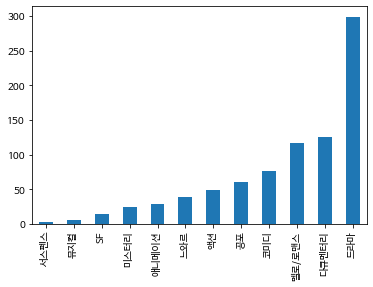

In [3]:
total['genre'].value_counts().sort_values().plot(kind='bar')

#### 3) screening_rat
+ label-encoding: 연령별이기 때문에 순서형 가능

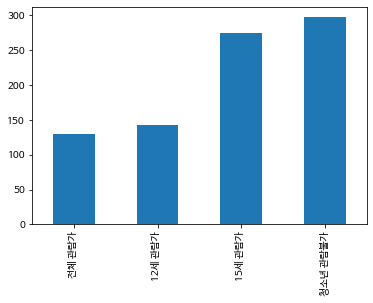

In [4]:
total['screening_rat'].value_counts().sort_values().plot(kind='bar')

+ `전체 관람가` -> `1`
+ `12세 관람가` -> `12`
+ `15세 관람가` -> `15`
+ `청소년 관람불가` -> `19`

In [5]:
size_mapping = {'전체 관람가':1,'12세 관람가':12,'15세 관람가':15, '청소년 관람불가':19}
total['screening_rat'] = total['screening_rat'].map(size_mapping)

total['screening_rat'].value_counts()

19    297
15    275
12    142
1     129
Name: screening_rat, dtype: int64

#### 4) director -> drop
+ uniqueness가 너무 크다

In [17]:
total.drop('director', axis=1, inplace=True)

#### 5) year, month, holiday

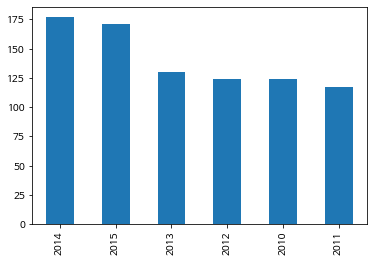

In [6]:
total['year'].value_counts().plot(kind='bar')

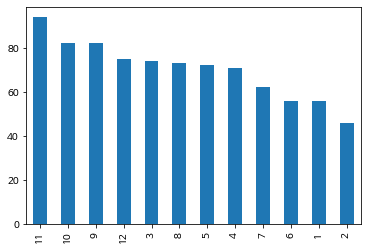

In [7]:
total['month'].value_counts().plot(kind='bar')

In [9]:
total['holiday'].value_counts()

False    828
True      15
Name: holiday, dtype: int64

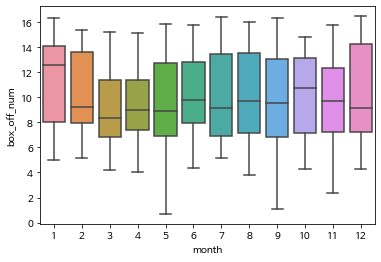

In [14]:
train = total[total['from']=='train'].drop('from', axis=1)
baxplot=plt.subplots()
boxplot=sns.boxplot(x='month', y='box_off_num', data=train)

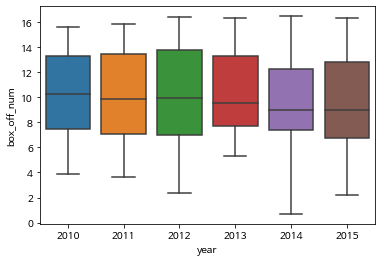

In [15]:
baxplot=plt.subplots()
boxplot=sns.boxplot(x='year', y='box_off_num', data=train)

+ 년도는 box_off_num에 크게 영향 주지 않음 --> drop

In [41]:
total.drop('year', axis=1, inplace=True)

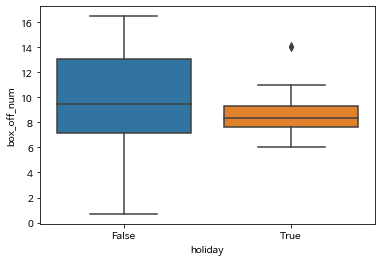

In [16]:
baxplot=plt.subplots()
boxplot=sns.boxplot(x='holiday', y='box_off_num', data=train)

In [1]:
# 나눔 폰트 설치
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지
# 출력 결과를 셀 아래 inline으로 표시
%matplotlib inline 
import warnings
warnings.filterwarnings(action='ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

! pip install pytimekr

# 전처리 모음
train = pd.read_csv("/content/drive/MyDrive/esaa_data/movies/movies_train.csv")
test = pd.read_csv("/content/drive/MyDrive/esaa_data/movies/movies_test.csv")
train['from'] = 'train'
test['from'] = 'test'
total = train.append(test)

total.drop('title', axis=1, inplace=True)

total['distributor'] = total['distributor'].replace(['CJ 엔터테인먼트', 'CJ E&M Pictures', 'CJ E&M 영화부문', 'CJ CGV', 'CGV 아트하우스', 'CGV아트하우스', 'CGV 무비꼴라쥬'], ['CJ']*7)
total['distributor'] = total['distributor'].replace(['마운틴 픽처스', '더픽쳐스/(주)마운틴픽쳐스', '(주)마운틴픽쳐스', '마운틴픽쳐스', '(주)씨타마운틴픽쳐스'], ['마운틴픽쳐스']*5)
total['distributor'] = total['distributor'].replace(['(주)쇼박스', '쇼박스(주)미디어플렉스' ], ['쇼박스']*2)
total['distributor'] = total['distributor'].replace(['(주)NEW', 'NEW' ], ['NEW']*2)
total['distributor'] = total['distributor'].replace(['KT&G 상상마당', 'KT' ], ['KT']*2)
total['distributor'] = total['distributor'].replace(['롯데엔터테인먼트', '롯데쇼핑(주)롯데엔터테인먼트' ], ['롯데']*2)
total['distributor'] = total['distributor'].replace(['싸이더스FNH', '싸이더스', '싸이더스 FNH'], ['싸이더스']*3)
total['distributor'] = total['distributor'].replace(['(주)리틀빅픽처스', '리틀빅픽처스', '리틀빅픽쳐스' ], ['리틀빅픽쳐스']*3)
total['distributor'] = total['distributor'].replace(['(주)마인스엔터테인먼트', '(주)마인스 엔터테인먼트' ], ['마인스엔터테인먼트']*2)
total['distributor'] = total['distributor'].replace(['SK플래닛', 'SK텔레콤(주)' ], ['SK']*2)
total['distributor'] = total['distributor'].replace(['(주)시네마달', '시네마 달', '시네마달' ], ['시네마달']*3)
total['distributor'] = total['distributor'].replace(['THE 픽쳐스', '(주)더픽쳐스' ], ['더픽쳐스']*2)
total['distributor'] = total['distributor'].replace(['메가박스중앙(주)플러스엠', '메가박스(주)플러스엠' ], ['메가박스']*2)
total['distributor'] = total['distributor'].replace(['(주)디씨드', '디씨드', '디 씨드' ], ['디씨드']*3)

total['release_time'] = pd.to_datetime(total['release_time']) 
total["year"] = total["release_time"].dt.year
total["month"] = total["release_time"].dt.month
from pytimekr import pytimekr
holiday = []
for i in range(2010, 2015):
    new = pytimekr.lunar_newyear(i) # 설날
    holiday.append(new)
    chi = pytimekr.children(i) # 어린이날
    holiday.append(chi)
    han = pytimekr.hangul(i) # 한글날
    holiday.append(han)
    ind = pytimekr.independence(i) # 광복절
    holiday.append(ind)
    chu = pytimekr.chuseok(i) # 추석
    holiday.append(chu)
    mem = pytimekr.memorial(i) # 헌충일
    holiday.append(mem)
    bud = pytimekr.buddha(i) # 석가탄신일
    holiday.append(bud)
    sam = pytimekr.samiljeol(i) # 삼일절
    holiday.append(sam)
    con = pytimekr.constitution(i) # 제헌절
    holiday.append(con)
def is_holiday(date):
  if date in holiday:
    return True
  else:
    return False
holidays = []
for i in total['release_time']:
  a = is_holiday(i)
  holidays.append(a)
total['holiday'] = holidays
total.drop(columns="release_time", axis=1, inplace=True)

total['dir_prev_bfnum']=total['dir_prev_bfnum'].fillna(0)

# 이상치
total.loc[total['time']==2015, 'time'] = 63

# numerical 변수 scaling
log_col = ['box_off_num', 'num_staff', 'dir_prev_num', 'dir_prev_bfnum']
standard_col = ['num_actor', 'time']
minmax_col = 'dir_prev_num'

# 로그 변환
total[log_col] = np.log1p(total[log_col])
# standardization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()
standard_scaler.fit(total[standard_col])
total[standard_col] = standard_scaler.transform(total[standard_col])
# min max scaling
#minmax_scaler = MinMaxScaler()
#minmax_scaler.fit(total[[minmax_col]]) # caution: single col은 series말고 dataframe으로 
#total[[minmax_col]] = minmax_scaler.transform(total[[minmax_col]])

# 5개 이하 영화 배급사
below5 = total.distributor.value_counts()<=5
below5 = below5[below5==True]
below5 = below5.index.tolist()
for i in below5:
  total.loc[total['distributor']==i, 'distributor'] = 'below5'

# screeing_rat label encoding
size_mapping = {'전체 관람가':1,'12세 관람가':12,'15세 관람가':15, '청소년 관람불가':19}
total['screening_rat'] = total['screening_rat'].map(size_mapping)

total.drop('year', axis=1, inplace=True)
total.drop('director', axis=1, inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
total =pd.get_dummies(data=total, columns = ['distributor', 'genre'])
total.head()

,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,month,holiday,...,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디
0,-0.283459,19,0.000000,0.000000,4.521789,-0.696722,10.060449,train,11,False,...,0,0,0,0,0,0,0,0,1,0
1,1.597646,19,13.965312,1.098612,5.961005,-0.272039,15.771725,train,11,False,...,1,0,0,0,0,0,0,0,0,0
2,1.210360,15,12.304905,1.609438,5.840642,0.152644,15.755558,train,6,False,...,0,0,0,0,0,0,0,0,1,0
3,-0.006826,1,10.081425,1.098612,3.044522,1.002011,12.291640,train,7,False,...,0,0,0,0,0,0,0,0,0,1
4,0.380461,15,0.693147,0.693147,5.529429,-0.696722,13.088575,train,11,False,...,0,0,0,0,0,0,0,0,0,1


In [3]:
total.columns

Index(['time', 'screening_rat', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff',
       'num_actor', 'box_off_num', 'from', 'month', 'holiday',
       'distributor_(주) 영화사조제', 'distributor_(주) 케이알씨지', 'distributor_(주)키노아이',
       'distributor_(주)팝엔터테인먼트', 'distributor_BoXoo 엔터테인먼트', 'distributor_CJ',
       'distributor_KT', 'distributor_NEW', 'distributor_below5',
       'distributor_골든타이드픽처스', 'distributor_나이너스엔터테인먼트(주)', 'distributor_롯데',
       'distributor_리틀빅픽쳐스', 'distributor_마운틴픽쳐스', 'distributor_마인스엔터테인먼트',
       'distributor_메가박스', 'distributor_무비꼴라쥬', 'distributor_쇼박스',
       'distributor_스폰지', 'distributor_시너지', 'distributor_시네마달',
       'distributor_시네마서비스', 'distributor_싸이더스', 'distributor_어뮤즈',
       'distributor_영화사 진진', 'distributor_인디스토리', 'distributor_인디플러그',
       'distributor_인벤트 디', 'distributor_필라멘트 픽쳐스', 'genre_SF', 'genre_공포',
       'genre_느와르', 'genre_다큐멘터리', 'genre_드라마', 'genre_멜로/로맨스', 'genre_뮤지컬',
       'genre_미스터리', 'genre_서스펜스', 'genre_애니메이션', 'genr

## | 모델링
---


In [3]:
train = total[total['from']=='train'].drop('from', axis=1)
test = total[total['from']=='test'].drop('from', axis=1)

X_features = train.drop('box_off_num', axis=1)
y_target = train['box_off_num'] # 로그 변환된 값

X_test = test.drop('box_off_num', axis=1)

In [5]:
X_features.shape

(600, 49)

In [6]:
y_target.shape

(600,)

In [7]:
X_test.shape

(243, 49)

## LinearRegression, Ridge, Lasso

In [18]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log()가 아닌 log1p()를 이용하여 RMSLE 계산
def rmsle(y, pred):
  # 로그 변환
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  
  # 오차 제곱 계산
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))

  return rmsle

# 사이킷런의 mean_square_error()를 이용하여 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산하는 성능 평가 함수
def evaluate_regr(y,pred):
  # RMLE, RMSE
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)

  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y,pred)

  print('RMSLE : {0:.3f}, RMSE : {1:.3F}, MAE : {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 학습/테스트 데이터셋 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

# model fitting
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_valid)

# model test
evaluate_regr(y_valid, pred)

RMSLE : 0.228, RMSE : 2.027, MAE : 1.563


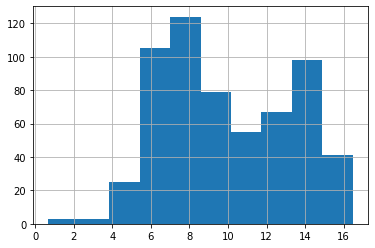

In [14]:
y_target.hist()

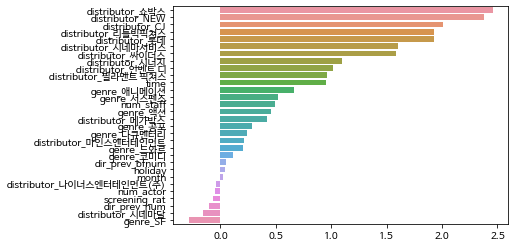

In [7]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)[:30]
sns.barplot(x = coef_sort.values, y = coef_sort.index)

In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse 구함
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_features, y_target, scoring = "neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 1.968 
alpha 0.1 일 때 5 folds의 평균 RMSE : 1.965 
alpha 1 일 때 5 folds의 평균 RMSE : 1.951 
alpha 10 일 때 5 folds의 평균 RMSE : 1.975 
alpha 100 일 때 5 folds의 평균 RMSE : 2.137 


+ alpha가 1일 때, 평균 RMSE가 가장 작다. 

In [11]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha = param)
        elif model_name =='Lasso': model = Lasso(alpha = param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha = param, l1_ratio = 0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = "neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE : {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
            coeff = pd.Series(data = model.coef_ , index = X_data_n.columns )
            colname ='alpha : ' + str(param)
            coeff_df[colname] = coeff
    
    return coeff_df
# end of get_linear_regre_eval

In [18]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.001, 0.003, 0.005,0.007, 0.01,0.03,0.05, 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_features, y_target_n = y_target)

#######  Lasso #######
alpha 0.001일 때 5 폴드 세트의 평균 RMSE : 1.961 
alpha 0.003일 때 5 폴드 세트의 평균 RMSE : 1.950 
alpha 0.005일 때 5 폴드 세트의 평균 RMSE : 1.948 
alpha 0.007일 때 5 폴드 세트의 평균 RMSE : 1.952 
alpha 0.01일 때 5 폴드 세트의 평균 RMSE : 1.962 
alpha 0.03일 때 5 폴드 세트의 평균 RMSE : 2.017 
alpha 0.05일 때 5 폴드 세트의 평균 RMSE : 2.082 
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 2.145 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 2.208 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 2.331 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 2.507 
alpha 3일 때 5 폴드 세트의 평균 RMSE : 3.008 


+ alpha가 0.005일 때 평균 rMSE값이 가장 작다. 

In [21]:
# 모델과 학습/테스트 데이터셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  # model fitting
  model.fit(X_train, y_train)
  pred = model.predict(X_test)

  # 원래 값으로 scale 변환
  if is_expm1 :
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)

  print('###',model.__class__.__name__,'###')

  # model test
  evaluate_regr(y_test, pred)
  
# model별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 1)
lasso_reg = Lasso(alpha = 0.005)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_valid, y_train, y_valid, is_expm1 = True)

### LinearRegression ###
RMSLE : 2.027, RMSE : 2377260.708, MAE : 621732.384
### Ridge ###
RMSLE : 2.027, RMSE : 2385032.631, MAE : 618818.444
### Lasso ###
RMSLE : 2.047, RMSE : 2336094.512, MAE : 612783.682


In [26]:
ridge_reg.fit(X_features, y_target)
pred = ridge_reg.predict(X_test)
pred = np.expm1(pred)

In [29]:
sub = pd.read_csv("/content/drive/MyDrive/esaa_data/movies/submission.csv")
sub['box_off_num'] = pred
sub.head()

,title,box_off_num
0,용서는 없다,7.868030e+05
1,아빠가 여자를 좋아해,8.695272e+05
2,하모니,4.945227e+05
3,의형제,2.583143e+06
4,평행 이론,8.214887e+05


In [30]:
sub.to_csv('/content/drive/MyDrive/esaa_data/movies/submission.csv', index=False)

+ 리더보드: 1570572.578222662

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [24]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print('##### ', model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))
    
dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]

for model in models:  
    get_model_cv_prediction(model, X_features, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 2.115 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 1.892 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 2.065 
[08:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 2.043 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 2.082 


In [31]:
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
rf_reg.fit(X_features, y_target)
rf_reg_pred = rf_reg.predict(X_test)
rf_reg_pred = np.expm1(rf_reg_pred)

In [33]:
sub['box_off_num'] = rf_reg_pred
sub.to_csv('/content/drive/MyDrive/esaa_data/movies/submission.csv', index=False)

+ 리더보드: 	1377208.1989272085	

In [42]:
from sklearn.model_selection import GridSearchCV
rf_reg = RandomForestRegressor()

params = {'n_estimators':[700, 800, 900, 1000, 1100],
    'max_depth':[3, 5, 7]}

gridcv = GridSearchCV(rf_reg, params)
gridcv.fit(X_features, y_target)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_) 

GridSearchCV 최적 파라미터: {'max_depth': 7, 'n_estimators': 800}


In [41]:
rf_best = gridcv.best_estimator_
rf_best.fit(X_features, y_target)
rf_pred = rf_best.predict(X_test)
rf_pred = np.expm1(rf_pred)

sub['box_off_num'] = rf_pred
sub.to_csv('/content/drive/MyDrive/esaa_data/movies/submission.csv', index=False)